In [2]:
# activate env and instantiate pkgs
using Pkg
Pkg.activate("../p1")
Pkg.instantiate()

  Activating project at `~/m420p1/p1`


In [3]:
using CSV, DataFrames, LaTeXStrings, Plots, Distances, JuMP, GLPK # import necessary pkgs

In [3]:
df = CSV.read("../resources/data.csv", DataFrame) # entire df

v_infected = values(df[1, 13:end]) # vector of infected numbers
infected_dates = names(df[1, 13:end]) # vector of infected_dates
@assert length(v_infected) == length(infected_dates)

# Exercise 1

## 1)

In [4]:
yd = values(df[2, 13:end]); 

In [5]:
v(t::Int)::Int = v_infected[t]
y(t::Int)::Int = yd[t];

In [6]:
findfirst([x>=5 for x in v_infected])

46

In [7]:
y_deaths = values(df[2, 13+46-1:end]); # vector of deaths

$T_{0} = 46$

In [8]:
function I(t::Int, τ::Int=7)::Real
    t0 = 46
    return v(t+t0+τ) - v(t+t0-τ)
end

I (generic function with 2 methods)

In [9]:
popu=df.Population[1];
tmax = 119;

In [10]:
# df = CSV.read("../resources/data.csv", DataFrame) # entire df

# read the values of infections and deaths from the table
infected = values(df[1, 13:end]) # vector of infected numbers
deaths = values(df[2, 13:end]) # vector of death numbers
infected_dates = names(df[1, 13:end]) # vector of infected_dates
population = df.Population[1];
@assert length(infected) == length(deaths)
# parameters
Vmin = 5
τ0 = 7
λ = 1

t0 = findfirst([x>=Vmin for x in infected])
tmax = 119
# define V, Y, and I for the range of times we are interested in
V(t) = infected[t + t0]
Y(t) = deaths[t + t0]
I(t) = infected[t + t0 + 7] - infected[t + t0 - 7]

I (generic function with 3 methods)

In [4]:
# function to find the optimal gamma for a given R_sim and p
@inline function optGammap2(R_sim::Vector{T}, yf::Function, tmax::Int=119)::Float64 where T<:Float64
    s1(t) = yf(t)*R_sim[t+1]
    s2(t) = abs(R_sim[t+1])^2
    gamma_c = sum(s1, 0:tmax)/sum(s2, 0:tmax)
    if gamma_c < 0 
        return 0.0
    elseif gamma_c > 1
        return 1.0
    else
        return gamma_c
    end
end

@inline function optGammapinf(R_sim::Vector{T}, yf::Function, tmax::Int=119)::Float64 where T<:Float64
    model = Model()
    set_optimizer(model, GLPK.Optimizer)
    
    @variable(model, x1>= 0)
    @variable(model, 1>=x2>=0)

    for t = 0:tmax
        @constraint(model, (-x1) - R_sim[t+1]*x2 <= -yf(t))
        @constraint(model, (-x1) + R_sim[t+1]*x2 <= yf(t))
    end

    @objective(model, Min, x1)
    optimize!(model)

    return value.(x2)
end

optGammapinf (generic function with 2 methods)

In [5]:
@inline function optGammap1(R_sim::Vector{T}, yf::Function, tmax::Int=119)::Float64 where T<:Float64
        r_vector = yf.(0:tmax)./R_sim
        filter!(!isinf, r_vector) # filter out r = x/0
        filter!(x -> x<=1, r_vector)
        filter!(x -> x>=0, r_vector)
        vf(r::Float64, tmax)::Float64 = Cityblock()(Y.(0:tmax), r*R_sim)
        md = Dict{Float64, Float64}(r_vector .=> vf.(r_vector, tmax))
        
        return argmin(md)
    end

optGammap1 (generic function with 2 methods)

In [6]:
# Euler scheme
@inline function euler(alpha::Real, beta::Real, N::Real, to::Int=120; h::Real=0.01)::NTuple{3, Vector{Float64}}
  n = 2

  S_sim = Vector{Float64}(undef, to)
  I_sim = Vector{Float64}(undef, to)
  R_sim = Vector{Float64}(undef, to)

  s = N # introduce Ntotal = sum (sir)
  i = I(0)
  r = 0
  N_total = s + i + r

  t = 0

  S_sim[1] = s
  I_sim[1] = i
  R_sim[1] = r
  n = 2
  c_target = 1/h
  c_current = 2
  _n = 1
  while n <= to # pass as var, alternative counter 1/h
    ds = -beta*s*(i/N_total) # replace with Ntotal, same SEIR
    di = beta*s*(i/N_total) - alpha*i
    dr = alpha*i
  
    s += h*ds
    i += h*di
    r += h*dr
    N_total = s + i + r
    t += h
    if c_current == c_target
      S_sim[n] = s
      I_sim[n] = i
      R_sim[n] = r
      n += 1
      c_current = 0
    end
    c_current += 1
    _n +=1
  end

  return S_sim, I_sim, R_sim
end

euler (generic function with 2 methods)

In [14]:
Y1 = first(y_deaths, 120);

In [15]:
@inline function J1(γ, Is, Rs, p, tmax::Real=119, λ::Real=1)::Real # generic vars
    f1(t) = abs(I(t) - Is[t+1])^p
    f2(t) = abs(y_deaths[t+1] - γ*Rs[t+1])^p
    return sum(f1, 0:tmax) + λ*sum(f2, 0:tmax)
end


J1 (generic function with 3 methods)

## $p=1$

In [21]:
Jd1 = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [22]:
Threads.@threads for α in 0.05:0.01:0.2
    Threads.@threads for r0 in 1.5:0.1:1.9
         Threads.@threads for nn in 2:0.5:10
            β = r0*α
            N = popu*nn/100
            Ss, Is, Rs = euler(α, β, N)
            γ̂  = optGammap1(Rs, Y)
            Jd1[(α, β, r0, N, γ̂)] = J1(γ̂, Is, Rs, 1)
        end
    end
end

In [23]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd1)
J_min = Jd1[argmin(Jd1)];

In [24]:
display(L"\text{For}  p=1")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=1$"

L"$J_{min}\approx 210876.271$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.17, 0.323, 1.9, 48861.18, 0.07909677731834515)


In [25]:
Jd1b = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [26]:
Threads.@threads for α in 0.17:0.01:0.19
    Threads.@threads for r0 in 1.9:0.1:2.5
        Threads.@threads for nn in 3:0.5:5
            β = r0*α
            N = popu*nn/100
            Ss, Is, Rs = euler(α, β, N, 40)
            γ̂  = optGammap1(Rs, Y, 39)
            Jd1b[(α, β, r0, N, γ̂)] = J1(γ̂, Is, Rs, 1, 39)
        end
    end
end

In [27]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd1b)
J_min = Jd1b[argmin(Jd1b)];
display(L"\text{For}  p=1")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=1$"

L"$J_{min}\approx 49403.388$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.19, 0.43699999999999994, 2.3, 48861.18, 0.030950214475672873)


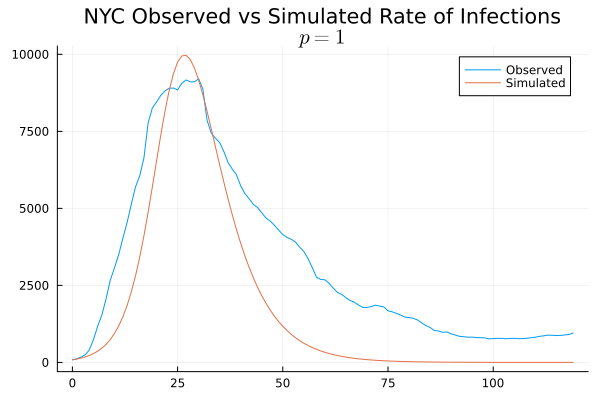

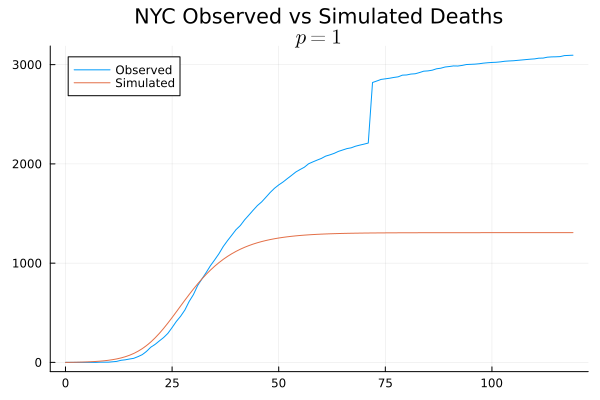

"prednycdtp1.svg"

In [28]:
Ss, Is, Rs = euler(α̂, β̂, N̂);
nm = ["prednycinfcp1", "prednycdtp1"]
plot(0:119, I, labels="Observed")
plot!(0:119, Is, label="Simulated")
display(plot!(title = "NYC Observed vs Simulated Rate of Infections" * "\n" * L"p=1"))
Plots.svg(nm[1])
plot(0:119, Y1, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
display(plot!(title = "NYC Observed vs Simulated Deaths" * "\n" * L"p=1"))
Plots.svg(nm[2])

### 2)

In [29]:
function Jplot(α, β, p)
    S, I, R = euler(α, β, N̂)
    return J1(γ̂, I, R, p)
end

Jplot (generic function with 1 method)

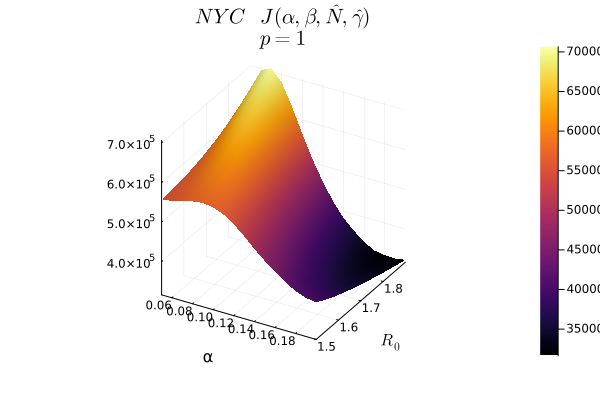

In [30]:
display(surface(0.05:0.01:0.2, 1.5:0.01:1.9, (x,y) -> Jplot(x, x*y, 1), title=L"NYC \quad J(\alpha, \beta, \hat{N}, \hat{\gamma})"*"\n"*L"p=1", xlabel="α", ylabel=L"R_{0}"))
# Plots.svg("p1surface_exercise1");

### 3)

In [24]:
Ss, Is, Rs = euler(α̂, β̂, N̂);

In [27]:
plot(0:119, I, labels="Observed")
plot!(0:119, Is, label="Simulated")
plot!(title = "NYC Observed vs Simulated Rate of Infections" * "\n" * L"p=1")
# Plots.svg("obsnycp1")

"obsnycp1.svg"

In [28]:
plot(0:119, Y1, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
plot!(title = "NYC Observed vs Simulated Deaths" * "\n" * L"p=1")
# Plots.svg("dnycp1")

"dnycp1.svg"

Big increase from 5/17/2020 to 5/18/2020 (+610 deaths). Only possible explanation: NYC health department changed from releasing daily pdf to uploading their data to GitHub right on this date.

#### $p=2$

In [29]:
Jd2 = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [30]:
Threads.@threads for α in 0.05:0.01:0.2
    Threads.@threads for r0 in 1.5:0.1:1.9
        Threads.@threads for nn in 2:0.5:10
            β = r0*α
            N = popu*nn/100
            Ss, Is, Rs = euler(α, β, N)
            γ̂  = optGammap2(Rs, Y)
            Jd2[(α, β, r0, N, γ̂)] = J1(γ̂, Is, Rs, 2)
        end
    end
end

In [31]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd2)
J_min = Jd2[argmin(Jd2)];

In [32]:
display(L"\text{For}  p=2")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=2$"

L"$J_{min}\approx 5.33628833613e8$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.2, 0.38, 1.9, 65148.24, 0.054092328587712436)


In [33]:
65148/popu

0.039999852643755225

In [31]:
Jd2b = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [32]:
Threads.@threads for α in 0.2:0.01:0.3
    Threads.@threads for r0 in 1.9:0.1:2.5
        Threads.@threads for nn in 4:0.5:5.5
            β = r0*α
            N = popu*nn/100
            Ss, Is, Rs = euler(α, β, N, 40)
            γ̂  = optGammap2(Rs, Y, 39)
            Jd2b[(α, β, r0, N, γ̂)] = J1(γ̂, Is, Rs, 2, 39)
        end
    end
end

In [33]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd2b)
J_min = Jd2b[argmin(Jd2b)];
display(L"\text{For}  p=2")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=2$"

L"$J_{min}\approx 9.3763816243e7$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.24, 0.504, 2.1, 65148.24, 0.02205158347328805)


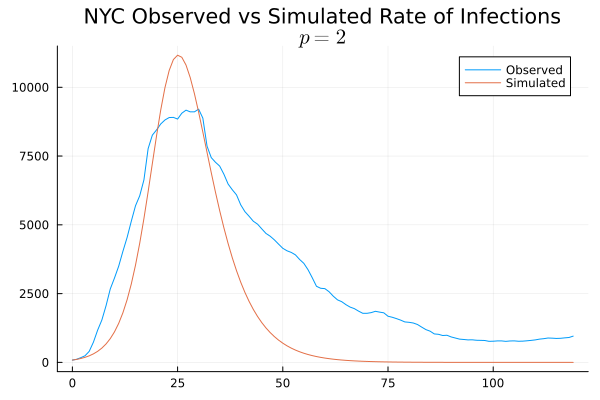

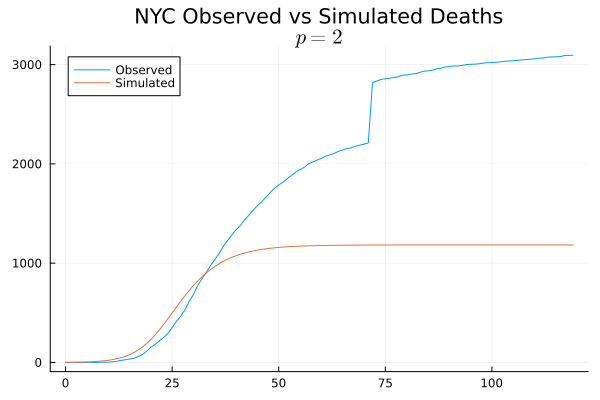

"prednycdtp2.svg"

In [34]:
Ss, Is, Rs = euler(α̂, β̂, N̂);
nm = ["prednycinfcp2", "prednycdtp2"]
plot(0:119, I, labels="Observed")
plot!(0:119, Is, label="Simulated")
display(plot!(title = "NYC Observed vs Simulated Rate of Infections" * "\n" * L"p=2"))
Plots.svg(nm[1])
plot(0:119, Y1, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
display(plot!(title = "NYC Observed vs Simulated Deaths" * "\n" * L"p=2"))
Plots.svg(nm[2])

### 2)

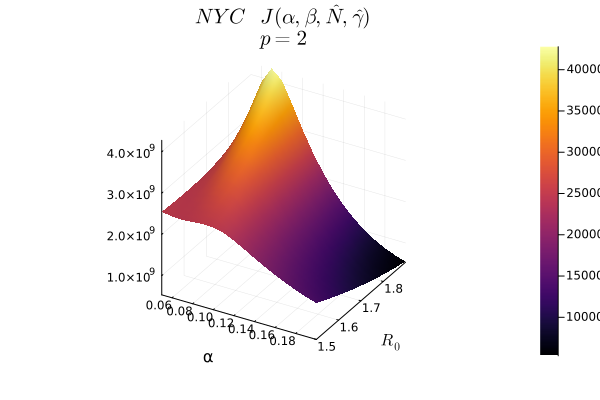

In [34]:
display(surface(0.05:0.01:0.2, 1.5:0.01:1.9, (x,y) -> Jplot(x, x*y, 2), title=L"NYC \quad J(\alpha, \beta, \hat{N}, \hat{\gamma})"*"\n"*L"p=2", xlabel="α", ylabel=L"R_{0}"))
Plots.svg("p2surface_exercise1");

### 3)

In [35]:
Ss, Is, Rs = euler(α̂, β̂, N̂);

In [36]:
plot(0:119, I, labels="Observed")
plot!(0:119, Is, label="Simulated")
plot!(title = "NYC Observed vs Simulated Rate of Infections" * "\n" * L"p=2")
Plots.svg("obsnycp2")

"obsnycp2.svg"

In [37]:
plot(0:119, Y1, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
plot!(title = "NYC Observed vs Simulated Deaths" * "\n" * L"p=2")
Plots.svg("dnycp2")

"dnycp2.svg"

### $p=\infty$

In [35]:
function J2(γ, Is, Rs, p, tmax::Real=119, λ::Real=1)::Float64
    f1(t) = abs(I(t) - Is[t+1])
    f2(t) = abs(y_deaths[t+1] - γ*Rs[t+1])
    return maximum(f1, 0:tmax) + λ*maximum(f2, 0:tmax)
end

J2 (generic function with 3 methods)

In [39]:
Jd3 = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [40]:
for α in 0.05:0.01:0.2
    for r0 in 1.5:0.1:1.9
        for nn in 2:0.5:10
            β = r0*α
            N = popu*nn/100
            Ss, Is, Rs = euler(α, β, N)
            γ̂  = optGammapinf(Rs, Y)
            Jd3[(α, β, r0, N, γ̂)] = J2(γ̂, Is, Rs, 2)
        end
    end
end

In [41]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd3)
J_min = Jd3[argmin(Jd3)];

In [42]:
display(L"\text{For}  p=∞")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=∞$"

L"$J_{min}\approx 6431.479$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.2, 0.38, 1.9, 81435.3, 0.042497751265925136)


In [43]:
81435/popu

0.04999981580469404

In [44]:
function Jplot2(α, β, p)
    S, I, R = euler(α, β, N̂)
    return J2(γ̂, I, R, p)
end

Jplot2 (generic function with 1 method)

In [36]:
Jd3b = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [37]:
Threads.@threads for α in 0.2:0.01:0.3
    Threads.@threads for r0 in 1.9:0.1:2.5
        Threads.@threads for nn in 5:0.5:8
            β = r0*α
            N = popu*nn/100
            Ss, Is, Rs = euler(α, β, N, 40)
            γ̂  = optGammapinf(Rs, Y, 39)
            Jd3b[(α, β, r0, N, γ̂)] = J1(γ̂, Is, Rs, 1, 39)
        end
    end
end

In [38]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd3b)
J_min = Jd3b[argmin(Jd3b)];
display(L"\text{For}  p=∞")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=∞$"

L"$J_{min}\approx 55331.907$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.28, 0.532, 1.9, 81435.3, 0.02037704665799641)


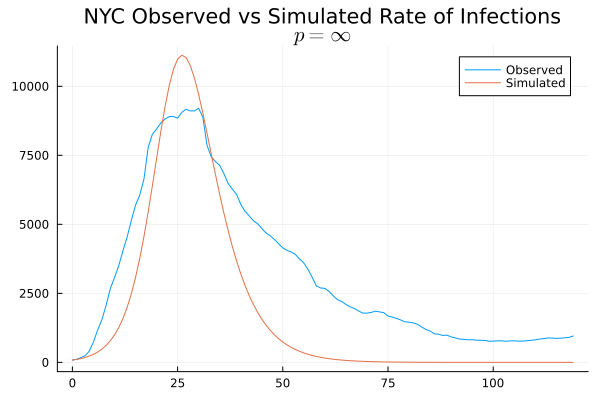

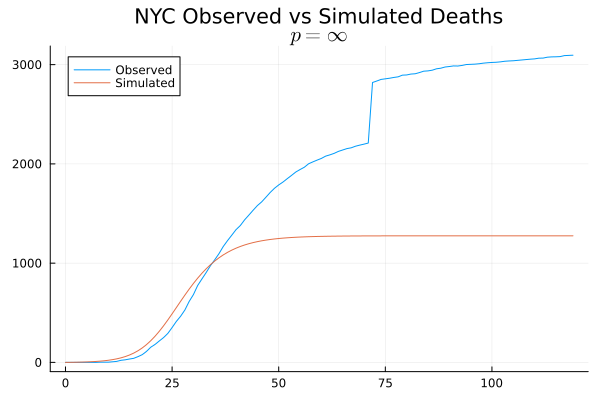

"prednycdtpinf.svg"

In [39]:
Ss, Is, Rs = euler(α̂, β̂, N̂);
nm = ["prednycinfcpinf", "prednycdtpinf"]
plot(0:119, I, labels="Observed")
plot!(0:119, Is, label="Simulated")
display(plot!(title = "NYC Observed vs Simulated Rate of Infections" * "\n" * L"p=∞"))
Plots.svg(nm[1])
plot(0:119, Y1, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
display(plot!(title = "NYC Observed vs Simulated Deaths" * "\n" * L"p=∞"))
Plots.svg(nm[2])

### 2)

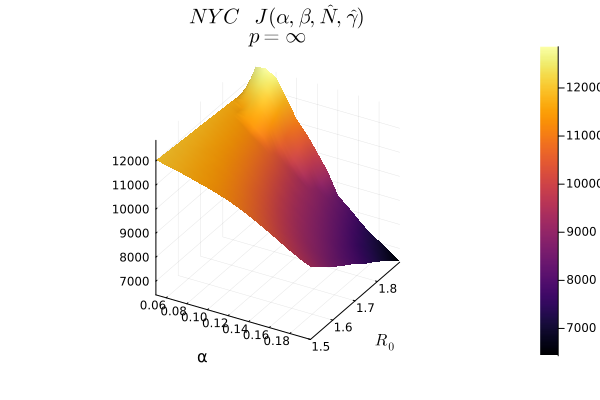

In [46]:
display(surface(0.05:0.01:0.2, 1.5:0.01:1.9, (x,y) -> Jplot2(x, x*y, 2), title=L"NYC \quad J(\alpha, \beta, \hat{N}, \hat{\gamma})"*"\n"*L"p=∞", xlabel="α", ylabel=L"R_{0}"))
Plots.svg("pinfsurface_exercise1");

### 3)

In [47]:
Ss, Is, Rs = euler(α̂, β̂, N̂);

In [48]:
plot(0:119, I, labels="Observed")
plot!(0:119, Is, label="Simulated")
plot!(title = "NYC Observed vs Simulated Rate of Infections" * "\n" * L"p=∞")
Plots.svg("obsnycinf")

"obsnycinf.svg"

In [49]:
plot(0:119, Y1, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
plot!(title = "NYC Observed vs Simulated Deaths" * "\n" * L"p=∞")
Plots.svg("dnycinf")

"dnycinf.svg"

# DC

In [7]:
dfdc = CSV.read("../resources/validation.csv", DataFrame) # entire df

# v_infected = values(df[1, 13:end]) # vector of infected numbers
# infected_dates = names(df[1, 13:end]) # vector of infected_dates
# @assert length(v_infected) == length(infected_dates)

2×1103 DataFrame
 Row │ UID       iso2     iso3     code3  FIPS   Admin2                Provinc ⋯
     │ Int64     String3  String3  Int64  Int64  String31              String3 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 84011001  US       USA        840  11001  District of Columbia  Distric ⋯
   2 │ 84011001  US       USA        840  11001  District of Columbia  Distric
                                                            1097 columns omitted

In [8]:
idc = values(dfdc[1, 13:end]);
infected_dates_dc = names(dfdc[1, 13:end]); # vector of infected_dates

In [9]:
population_dc = dfdc.Population[1];
deathsdc = values(dfdc[2, 13:end]) # vector of death numbers
# parameters
Vmin = 5
# τ0 = 7
# λ = 1

t0 = findfirst([x>=Vmin for x in idc])
tmax = 119
y_deaths_dc = values(dfdc[2, 13+t0-1:end]); # vector of deaths
# define V, Y, and I for the range of times we are interested in
Vdc(t) = idc[t + 7]
Ydc(t) = deathsdc[t + 7]
Idc(t) = idc[t + t0 + 7] - idc[t + t0 - 7]

Idc (generic function with 1 method)

In [10]:
# Euler scheme
@inline function eulerdc(alpha::Real, beta::Real, N::Real, to::Int=120; h::Real=0.01)::NTuple{3, Vector{Float64}}
  n = 2

  S_sim = Vector{Float64}(undef, to)
  I_sim = Vector{Float64}(undef, to)
  R_sim = Vector{Float64}(undef, to)

  s = N # introduce Ntotal = sum (sir)
  i = Idc(0)
  r = 0
  N_total = s + i + r

  t = 0

  S_sim[1] = s
  I_sim[1] = i
  R_sim[1] = r
  n = 2
  c_target = 1/h
  c_current = 2
  _n = 1
  while n <= to # pass as var, alternative counter 1/h
    ds = -beta*s*(i/N_total) # replace with Ntotal, same SEIR
    di = beta*s*(i/N_total) - alpha*i
    dr = alpha*i
  
    s += h*ds
    i += h*di
    r += h*dr
    N_total = s + i + r
    t += h
    if c_current == c_target
      S_sim[n] = s
      I_sim[n] = i
      R_sim[n] = r
      n += 1
      c_current = 0
    end
    c_current += 1
    _n +=1
  end

  return S_sim, I_sim, R_sim
end

eulerdc (generic function with 2 methods)

In [11]:
Y2 = first(y_deaths_dc, 120);

In [24]:
function J1dc(γ, Is, Rs, p, tmax::Int64=119, λ::Real=1)::Real # generic vars
    f1(t) = abs(Idc(t) - Is[t+1])^p
    f2(t) = abs(deathsdc[t+1] - γ*Rs[t+1])^p
    return sum(f1, 0:tmax) + λ*sum(f2, 0:tmax)
end


J1dc (generic function with 3 methods)

## $p=1$

In [113]:
Jd1dc= Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [114]:

Threads.nthreads()

10

In [115]:
Threads.@threads for α in 0.05:0.01:0.2
    Threads.@threads for r0 in 1.5:0.1:1.9
        Threads.@threads for nn in 2:0.5:10
            β = r0*α
            N = population_dc*nn/100
            Ss, Is, Rs = eulerdc(α, β, N)
            γ̂  = optGammap1(Rs, Ydc)
            Jd1dc[(α, β, r0, N, γ̂)] = J1dc(γ̂, Is, Rs, 1)
        end
    end
end

In [116]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd1dc)
J_min = Jd1dc[argmin(Jd1dc)];

In [117]:
display(L"\text{For}  p=1")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=1$"

L"$J_{min}\approx 50075.379$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.1, 0.19, 1.9, 17643.725, 0.032868655868553226)


In [118]:
17643/population_dc

0.024998972722596845

In [22]:
Jd1bdc = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [23]:
Threads.@threads for α in 0.1:0.01:0.19
    Threads.@threads for r0 in 1.7:0.1:2.2
        Threads.@threads for nn in 2.5:0.5:4
            β = r0*α
            N = population_dc*nn/100
            Ss, Is, Rs = eulerdc(α, β, N, 40)
            γ̂  = optGammap1(Rs, Ydc, 39)
            Jd1bdc[(α, β, r0, N, γ̂)] = J1dc(γ̂, Is, Rs, 1, 39)
        end
    end
end

In [24]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd1bdc)
J_min = Jd1bdc[argmin(Jd1bdc)];
display(L"\text{For}  p=1")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=1$"

L"$J_{min}\approx 32528.311$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.19, 0.342, 1.8, 17643.725, 0.2023520021841907)


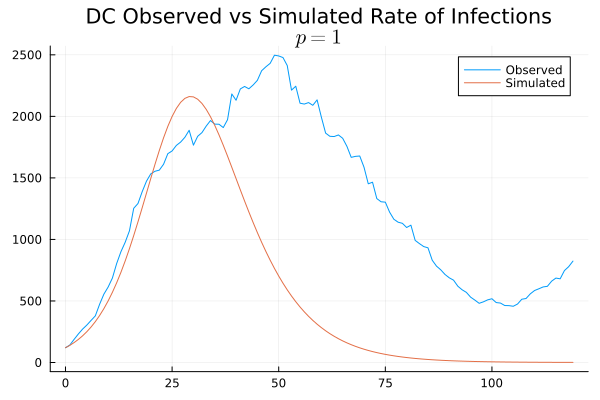

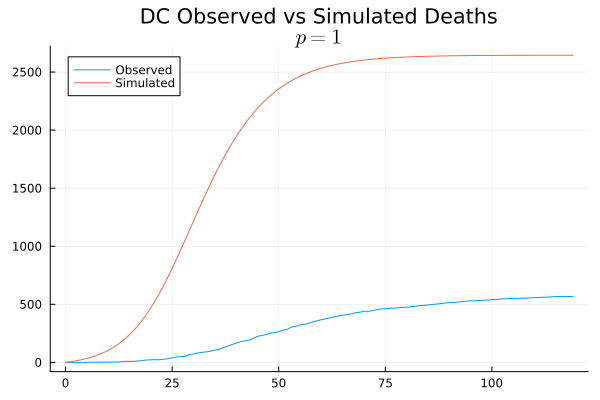

"preddcdtp1.svg"

In [25]:
Ss, Is, Rs = eulerdc(α̂, β̂, N̂);
nm = ["preddcinfcp1", "preddcdtp1"]
plot(0:119, Idc, labels="Observed")
plot!(0:119, Is, label="Simulated")
display(plot!(title = "DC Observed vs Simulated Rate of Infections" * "\n" * L"p=1"))
Plots.svg(nm[1])
plot(0:119, Y2, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
display(plot!(title = "DC Observed vs Simulated Deaths" * "\n" * L"p=1"))
Plots.svg(nm[2])

### 2)

In [119]:
function Jplotdc(α, β, p)
    S, I, R = eulerdc(α, β, N̂)
    return J1dc(γ̂, I, R, p)
end

Jplotdc (generic function with 1 method)

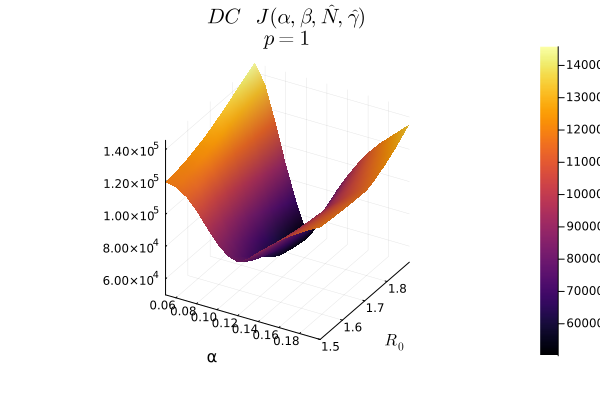

"dcsurp1.svg"

In [120]:
display(surface(0.05:0.01:0.2, 1.5:0.01:1.9, (x,y) -> Jplotdc(x, x*y, 1), title=L"DC \quad J(\alpha, \beta, \hat{N}, \hat{\gamma})"*"\n"*L"p=1", xlabel="α", ylabel=L"R_{0}"))
Plots.svg("dcsurp1")

### 3)

In [121]:
Ss, Is, Rs = eulerdc(α̂, β̂, N̂);

In [123]:
plot(0:119, Idc, labels="Observed")
plot!(0:119, Is, label="Simulated")
plot!(title = "DC Observed vs Simulated Rate of Infections" * "\n" * L"p=1")
Plots.svg("dcobsp1");

In [125]:
plot(0:119, Y2, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
plot!(title = "DC Observed vs Simulated Deaths" * "\n" * L"p=1")
Plots.svg("dcdeathsp1");

#### $p=2$

In [126]:
Jd2dc = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [127]:
Threads.@threads for α in 0.05:0.01:0.2
    Threads.@threads for r0 in 1.5:0.1:1.9
        Threads.@threads for nn in 2:0.5:10
            β = r0*α
            N = population_dc*nn/100
            Ss, Is, Rs = eulerdc(α, β, N)
            γ̂  = optGammap2(Rs, Ydc)
            Jd2dc[(α, β, r0, N, γ̂)] = J1dc(γ̂, Is, Rs, 2)
        end
    end
end

In [128]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd2dc)
J_min = Jd2dc[argmin(Jd2dc)];

In [129]:
display(L"\text{For}  p=2")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=2$"

L"$J_{min}\approx 1.564688434e7$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.12, 0.216, 1.8, 21172.47, 0.013354435401858933)


In [130]:
21172/population_dc

0.029999334040855884

In [26]:
Jd2bdc = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [27]:
Threads.@threads for α in 0.12:0.01:0.15
    Threads.@threads for r0 in 1.5:0.1:2.2
        Threads.@threads for nn in 3:0.5:4.5
            β = r0*α
            N = population_dc*nn/100
            Ss, Is, Rs = eulerdc(α, β, N, 40)
            γ̂  = optGammap2(Rs, Ydc, 39)
            Jd2bdc[(α, β, r0, N, γ̂)] = J1dc(γ̂, Is, Rs, 2, 39)
        end
    end
end

In [28]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd2bdc)
J_min = Jd2bdc[argmin(Jd2bdc)];
display(L"\text{For}  p=2")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=2$"

L"$J_{min}\approx 3.6761679853e7$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.15, 0.27, 1.8, 21172.47, 0.2997841902365145)


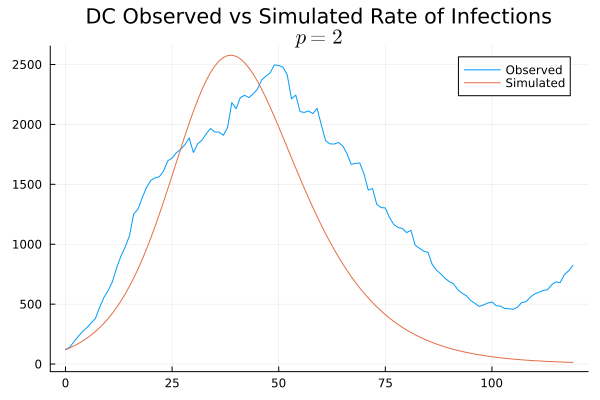

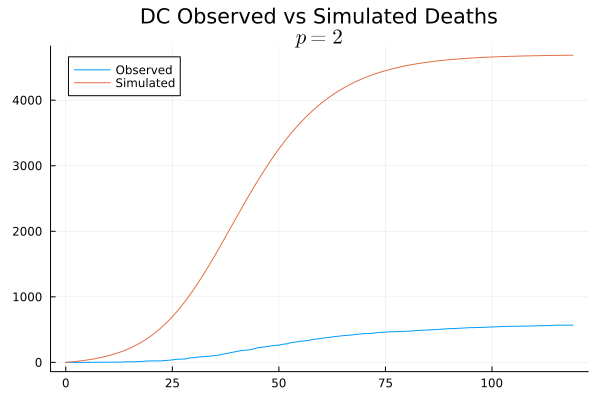

"preddcdtp2.svg"

In [29]:
Ss, Is, Rs = eulerdc(α̂, β̂, N̂);
nm = ["preddcinfcp2", "preddcdtp2"]
plot(0:119, Idc, labels="Observed")
plot!(0:119, Is, label="Simulated")
display(plot!(title = "DC Observed vs Simulated Rate of Infections" * "\n" * L"p=2"))
Plots.svg(nm[1])
plot(0:119, Y2, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
display(plot!(title = "DC Observed vs Simulated Deaths" * "\n" * L"p=2"))
Plots.svg(nm[2])

### 2)

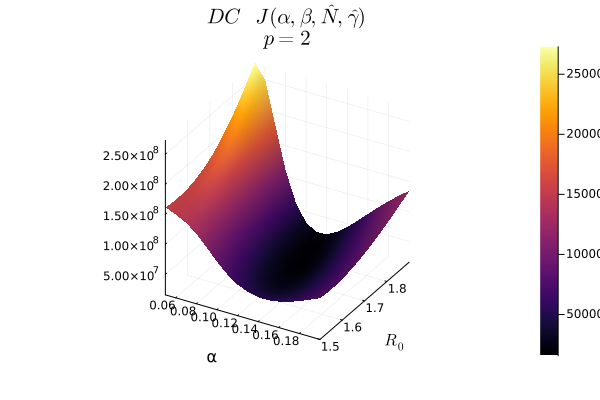

"dcsurp2.svg"

In [131]:
display(surface(0.05:0.01:0.2, 1.5:0.01:1.9, (x,y) -> Jplotdc(x, x*y, 2), title=L"DC \quad J(\alpha, \beta, \hat{N}, \hat{\gamma})"*"\n"*L"p=2", xlabel="α", ylabel=L"R_{0}"))
Plots.svg("dcsurp2")
# png("p2surface_exercise1");

### 3)

In [132]:
Ss, Is, Rs = eulerdc(α̂, β̂, N̂);

In [134]:
plot(0:119, Idc, labels="Observed")
plot!(0:119, Is, label="Simulated")
plot!(title = "DC Observed vs Simulated Rate of Infections" * "\n" * L"p=2")
Plots.svg("dcobsp2")

"dcobsp2.svg"

In [136]:
plot(0:119, Y2, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
plot!(title = "DC Observed vs Simulated Deaths" * "\n" * L"p=2")
Plots.svg("dcdeap2")

"dcdeap2.svg"

### $p=\infty$

In [12]:
function J2dc(γ, Is, Rs, tmax::Int=119, λ::Int=1)::Float64
    f1(t) = abs(Idc(t) - Is[t+1])
    f2(t) = abs(y_deaths_dc[t+1] - γ*Rs[t+1])
    return maximum(f1, 0:tmax) + λ*maximum(f2, 0:tmax)
end

J2dc (generic function with 3 methods)

In [21]:
Jd3dc = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [17]:
Threads.@threads for α in 0.05:0.01:0.2
    Threads.@threads for r0 in 1.5:0.1:1.9
        Threads.@threads for nn in 2:0.5:10
            β = r0*α
            N = population_dc*nn/100
            Ss, Is, Rs = eulerdc(α, β, N)
            γ̂  = optGammapinf(Rs, Ydc)
            Jd3dc[(α, β, r0, N, γ̂)] = J2dc(γ̂, Is, Rs)
        end
    end
end

In [140]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd3dc)
J_min = Jd3dc[argmin(Jd3dc)];

In [141]:
display(L"\text{For}  p=∞")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=∞$"

L"$J_{min}\approx 1079.246$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.13, 0.234, 1.8, 24701.215, 0.013853588953213118)


In [142]:
24701/population_dc

0.03499969535911493

In [143]:
function Jplot2dc(α, β, p)
    S, I, R = eulerdc(α, β, N̂)
    return J2dc(γ̂, I, R, p)
end

Jplot2dc (generic function with 1 method)

In [13]:
Jd3bdc = Dict{NTuple{5, Float64}, Float64}()

Dict{NTuple{5, Float64}, Float64}()

In [16]:
Threads.@threads for α in 0.18:0.01:0.25
    Threads.@threads for r0 in 1.8:0.1:2.8
        Threads.@threads for nn in 3.5:0.5:5
            β = r0*α
            N = population_dc*nn/100
            Ss, Is, Rs = eulerdc(α, β, N, 40)
            γ̂  = optGammapinf(Rs, Ydc, 39)
            Jd3bdc[(α, β, r0, N, γ̂)] = J2dc(γ̂, Is, Rs, 39)
        end
    end
end

UndefVarError: UndefVarError: Y not defined

In [24]:
α̂, β̂, r0̂, N̂, γ̂ = argmin(Jd3bdc)
J_min = Jd3bdc[argmin(Jd3bdc)];
display(L"\text{For}  p=∞")
@show α̂, β̂, r0̂, N̂, γ̂;
display(L"J_{min}\approx %$(round(J_min, digits=3))")

L"$\text{For}  p=∞$"

L"$J_{min}\approx 2925.212$"

(α̂, β̂, r0̂, N̂, γ̂) = (0.22, 0.396, 1.8, 24701.215, 0.13014338811765608)


In [1]:
Ss, Is, Rs = eulerdc(α̂, β̂, N̂);
nm = ["preddcinfcpinf", "preddcdtpinf"]
plot(0:119, Idc, labels="Observed")
plot!(0:119, Is, label="Simulated")
display(plot!(title = "DC Observed vs Simulated Rate of Infections" * "\n" * L"p=∞"))
Plots.svg(nm[1])
plot(0:119, Y2, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
display(plot!(title = "DC Observed vs Simulated Deaths" * "\n" * L"p=∞"))
Plots.svg(nm[2])

UndefVarError: UndefVarError: eulerdc not defined

### 2)

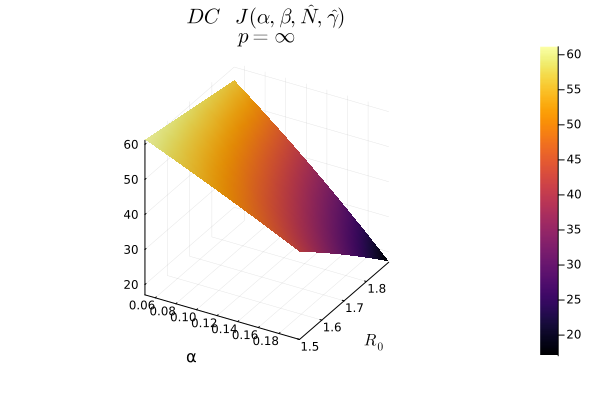

"dcsurpinf.svg"

In [144]:
display(surface(0.05:0.01:0.2, 1.5:0.01:1.9, (x,y) -> Jplot2dc(x, x*y, 2), title=L"DC \quad J(\alpha, \beta, \hat{N}, \hat{\gamma})"*"\n"*L"p=∞", xlabel="α", ylabel=L"R_{0}"))
Plots.svg("dcsurpinf")

### 3)

In [145]:
Ss, Is, Rs = euler(α̂, β̂, N̂);

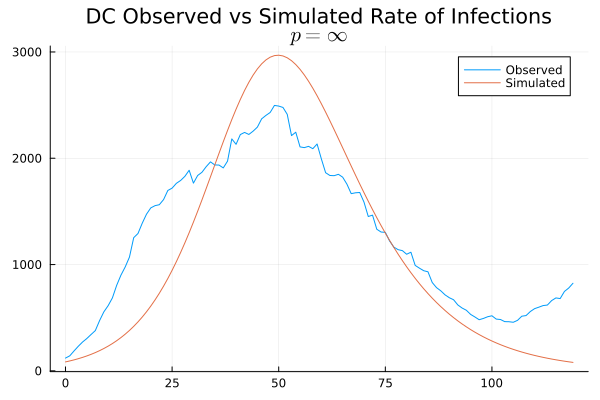

"dcobpinf.svg"

In [146]:
plot(0:119, Idc, labels="Observed")
plot!(0:119, Is, label="Simulated")
display(plot!(title = "DC Observed vs Simulated Rate of Infections" * "\n" * L"p=∞"))
Plots.svg("dcobpinf")

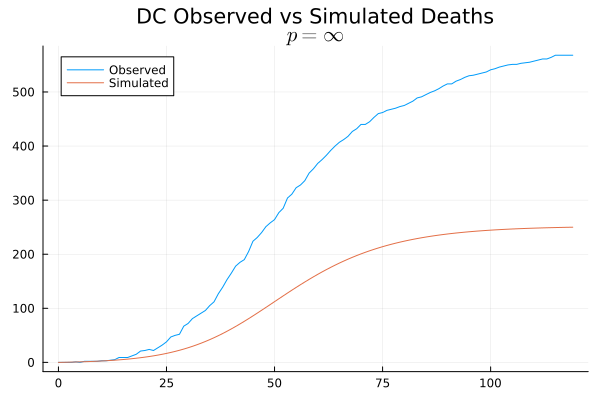

"dcdeathpinf.png"

In [148]:
plot(0:119, Y2, labels="Observed")
plot!(0:119, γ̂*Rs, label="Simulated")
display(plot!(title = "DC Observed vs Simulated Deaths" * "\n" * L"p=∞"))
Plots.png("dcdeathpinf")